## Run the CNN-RNN model

In [1]:
# restore saved best model
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
from tensorflow_docs.vis import embed
from imutils import paths
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import pickle
import math
import time

import tensorflow as tf
from tensorflow import keras

In [4]:
# Import Dataset
!cp /content/gdrive/MyDrive/ucf101.tar.gz /content

In [5]:
!tar xf ucf101.tar.gz

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 9537
Total videos for testing: 3783


,video_name,tag
7571,v_SkateBoarding_g11_c01.avi,SkateBoarding
748,v_Basketball_g20_c07.avi,Basketball
4777,v_Knitting_g18_c04.avi,Knitting
6527,v_PommelHorse_g08_c04.avi,PommelHorse
4298,v_JavelinThrow_g16_c04.avi,JavelinThrow
3560,v_HandStandPushups_g22_c02.avi,HandstandPushups
4273,v_JavelinThrow_g11_c05.avi,JavelinThrow
3111,v_GolfSwing_g16_c04.avi,GolfSwing
608,v_BaseballPitch_g14_c01.avi,BaseballPitch
9006,v_UnevenBars_g09_c04.avi,UnevenBars


In [7]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)

### Load the model

In [9]:
# Load model
!cp /content/gdrive/MyDrive/RNN-best-model.hdf5 /content
rnn_model = keras.models.load_model("RNN-best-model.hdf5")

In [10]:
# setting hyperparamters for capturing frame features
IMG_SIZE = 224
FPS = 6
MAX_FRAMES = 0    #0 implies get all frames
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1280

# MAX_FRAMES can only limit the number of frames extracted from the video.
# If MAX_FRAMES < MAX_SEQ_LENGTH then it must be set to 0.

In [11]:
# Defining feature extractor
def build_feature_extractor():
    feature_extractor = keras.applications.mobilenet_v2.MobileNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.mobilenet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)   #images are normalized here

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
# Helper functions

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=MAX_FRAMES, resize=(IMG_SIZE, IMG_SIZE)):
    Frames_to_skip = math.floor(25/FPS) - 1 #UCF101 videos are 25fps capped
    cap = cv2.VideoCapture(path)
    frames = []
    try:
      
        target = Frames_to_skip
        counter = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if counter == target:     # To get desired fps for videocapture
              frame = crop_center_square(frame)
              frame = cv2.resize(frame, resize)
              frame = frame[:, :, [2, 1, 0]]
              frames.append(frame)

              if len(frames) == max_frames:
                  break
              
              counter = 0   #reset fps counter

            else:
              counter += 1

    finally:
        cap.release()
    return np.array(frames)

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = rnn_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=FPS)
    return embed.embed_file("animation.gif")


### Run the model for any test example

Test video path: v_FrontCrawl_g05_c04.avi
  FrontCrawl: 99.14%
  BreastStroke:  0.47%
  Diving:  0.07%
  Rowing:  0.05%
  Rafting:  0.03%



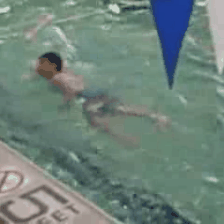

In [14]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])